In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ctrl_mult_mod import ctrl_mult_mod
from math import pi

def semi_classical_QFT_inv(qc,q_reg,c_reg):
    """ Aplica a IQFT semi clássica
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    """
    try:
        n = q_reg.size
    except:
        n = len(q_reg)
    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))),q_reg[i])
            # with else_:
            #     pass
        qc.h(q_reg[i])
        qc.measure(q_reg[i],c_reg[n-1-i])

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n-1, n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n, do_swaps=False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def gcdExtended(a, b): 
    # Base Case 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    # Update x and y using results of recursive 
    # call 
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    """Retorna o inverso modular x^-1 mod p"""
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

In [ ]:
def simbolo_de_jacobi(a, n):
    """
    a = numerador
    n = denominador
    """

    a %= n
    t = 1
    while a != 0:
        while a % 2 == 0:
            a /= 2
            r = n % 8
            if r == 3 or r == 5:
                t = -t
        a, n = n, a
        if a % 4 == 3 and n % 4 == 3:
            t = -t
        a %= n
    if n == 1:
        return t
    else:
        return 0


In [ ]:
from qiskit.circuit.library import QFT

"""Valores:
    b*A^x mod N : x é o valor em superposição
    b é inicializado como 1.
"""

N = 33  # N = p*q; p, q primos
n_bits = N.bit_length()

bases = []
for i in range(1000):
    if simbolo_de_jacobi(i, N) == -1:
        bases.append(i)

A = bases[0] # Base do expoente

x_bits = 6 # q=2**x_bits, tamanho da amostra, idealmente = 2*n_bits


reg_x = QuantumRegister(x_bits, "x") # Registrador da superposição

reg_b = QuantumRegister(n_bits, "b") # Registrador do valor b, iniciado como 1

# Registradores Ancillas
reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")


reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
expmod = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, name="expmod")

qc = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, reg_result)


qc.h(reg_x)
qc.x(reg_b[0])

for i in range(x_bits):

        expmod.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        a_inv = mod_inverse(A**(2**i), N)

        expmod.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[i:i+1] + reg_0[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            expmod.cswap(reg_x[i], reg_b[j], reg_0[j])


qc.append(expmod, reg_x[:] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

qc.append(QFT(x_bits).inverse(), reg_x[:])
#qft_simplificada = QuantumCircuit(x_bits)
#qft(qft_simplificada, n_bits)

#qc.append(qft_simplificada.inverse(), reg_x)

qc.measure(reg_x[:], reg_result)

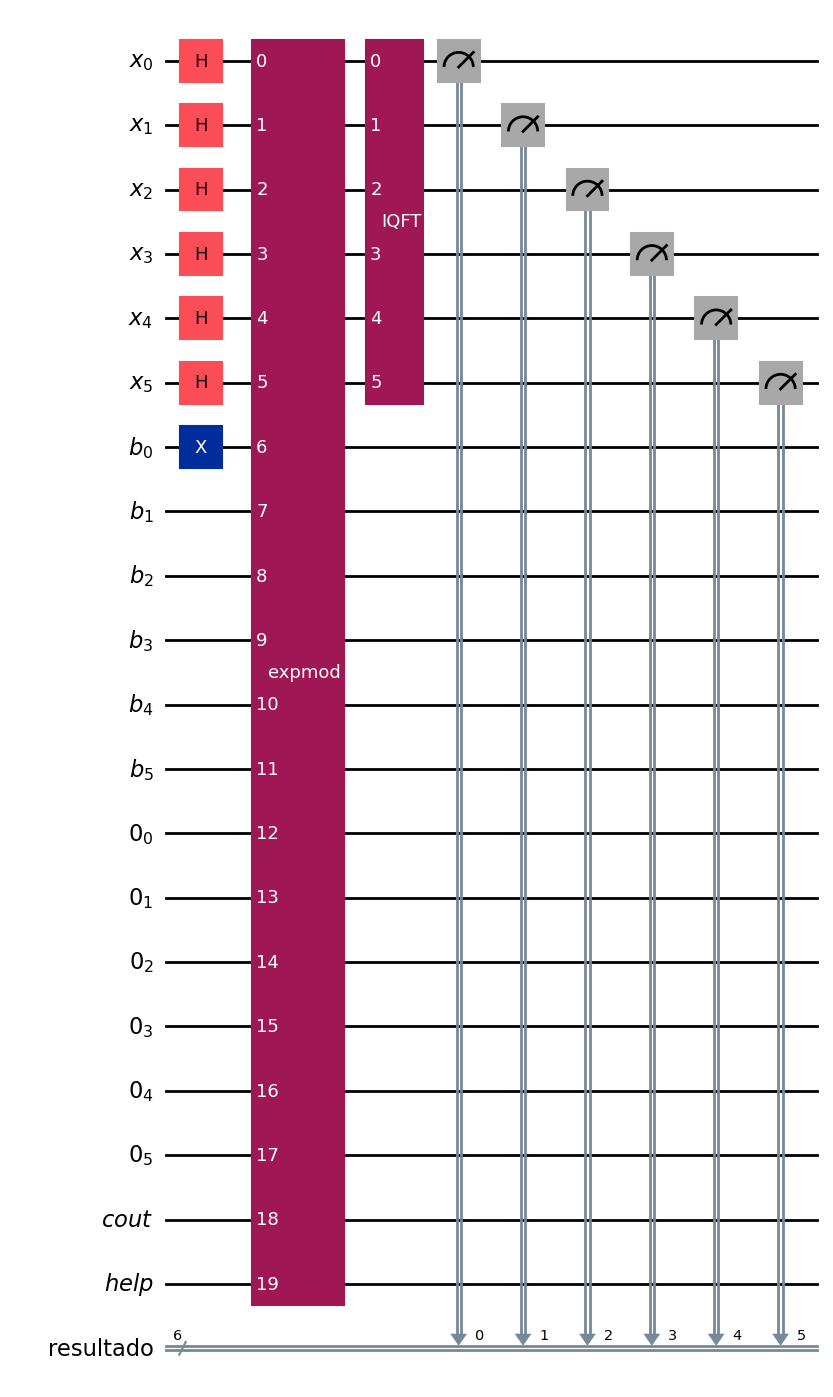

In [ ]:
#expmod.draw("mpl")
#qc.draw("mpl")

In [4]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1)
#print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)


{51: 1}


In [5]:
lcounts = []

for i in counts:
    lcounts.append((i, counts[i]))

lcounts.sort(reverse=True, key=lambda x: x[1])
print(lcounts)

[(51, 1)]


In [6]:
from math import gcd

def algoritmo_fracoes_continuas(a, b):
    """Calcula os termos de uma fração continuada do número a/b
    """

    if gcd(a,b) != 1:
        mdc = gcd(a,b)
        a = a//mdc
        b = b//mdc

    l = []

    if a < b:
        l.append(0)
        return l + algoritmo_fracoes_continuas(b, a)

    l.append(a//b)

    if b == 1:
        return l
    
    return l + algoritmo_fracoes_continuas(b, a % b)

def desfazer_fracoes_continuas(l, aproximacao):
    a, b = 1, l[len(l)-1-aproximacao]

    for i in range(len(l)-2-aproximacao, -1, -1):
        a, b = b, l[i]*b + a
    
    return b, a

r_possiveis = []
listafracs = []

for i in range(len(lcounts)):
    listaatual = []
    if lcounts[i][0] != 0:
        l = algoritmo_fracoes_continuas(lcounts[i][0], 2**x_bits)
        #print(str(lcounts[i][0]) + "/" + str(2**x_bits), l)
        listaatual.append(str(lcounts[i][0]) + "/" + str(2**x_bits))
        if l[0] != 0:
            for i in range(len(l)):
                listaatual.append(desfazer_fracoes_continuas(l, aproximacao=i))
                r_possiveis.append(val[1])
                listaatual.append(str(val[0]) + "/" + str(val[1]))
        else: 
            for i in range(1, len(l)-1):
                val = desfazer_fracoes_continuas(l, aproximacao=i)
                r_possiveis.append(val[1])
                listaatual.append(str(val[0]) + "/" + str(val[1]))
        listafracs.append(listaatual)

print(listafracs)
print(r_possiveis)

[['51/64', '4/5', '3/4', '1/1']]
[5, 4, 1]


In [ ]:
def verificar_r(lista_r, bases, N):
    valores_obtidos = set()
    for base in bases:
      r_testados = set()
      for i in lista_r:
        if i < N and i not in r_testados:
          mdc = gcd(base**i - 1, N)
          if mdc != 1:
            valores_obtidos.add(mdc)
          r_testados.add(i)
    return valores_obtidos

print(verificar_r(r_possiveis, bases, N))

10


In [8]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 0

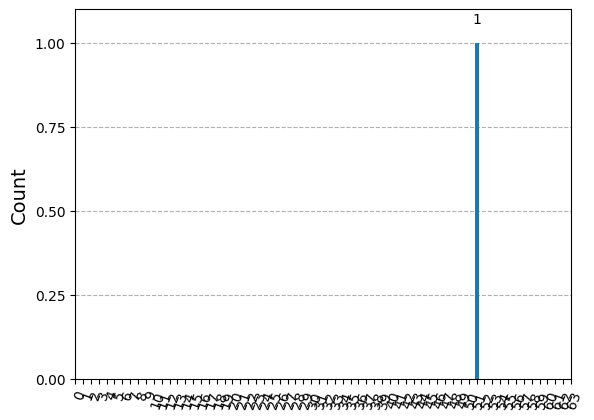

In [9]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)